# Best orbital parameters
## Search with chipot

We explore the 3d-space of the orbital parameters using the intensity profile. For each set of orbital parameters, $K$, $v_\mathrm{rad}$, and $\phi$, we use the ZDI technique to reconstruct the brightness map of the star. Then, we minimize the spot coverage information got from these maps to obtain the best orbital parameters. 

## DATA IN 2004  
- Total of 231 sub-exposures in November. Four of them were discarded of the data.

  \begin{equation*} SP_{\mathrm{ph}} = 0.14 \end{equation*}


In [19]:
#Global levels
lev_k = (148.90,149.6)
lev_phase = (-0.0044,-0.0031)
lev_vrad = (34.40,34.80)

### results form 3d-fit in 2004:

The error bar are expressed below. We used the eq. in Logithan's thesis dividing by the correspondent number of points used in total.

In [24]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq, least_squares
import cmocean as cm
import matplotlib
P.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", family="Times New Roman", size=12)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Define the number of sigmas that you want to consider 
nsigma=7.

# Read file with informations in each run
amp, phase, vrad, chisq, s, sp_ph, test, cool, hot = N.genfromtxt('data/search_3d_2004_chipot.txt', unpack=True)

#First read the number of points in the data:
cycle, vr, snI, I, cycleV, vrV, snV, V = rstokes('data/v471tau_04.ss')
count=0
for i in range(len(cycle)):
    count += I[i].shape[0]
    
print(count)
#Compute the corresponding variation in reduced chisq
dchisq = nsigma**2*3.53
    
# Set global min of chisq
chisq *= count
vmin = chisq.min()
print('chisq_min =', vmin)

#Set levels for plotting
lev = [vmin + isigma**2*(3.53) for isigma in range(int(nsigma)+1)]
cut_sigma = int(nsigma) + 2
lev_1 = [vmin + isigma**2*(3.53) for isigma in range(1,cut_sigma,2)]

#select data within the conditions:
ic = N.bitwise_and(N.bitwise_and(sp_ph <= 0.1405, sp_ph >= 0.1395), test <= 0.005)
amp = amp[ic]; phase = phase[ic]; vrad = vrad[ic]; chisq = chisq[ic]; s = s[ic]
sp_ph = sp_ph[ic]; test = test[ic]; cool = cool[ic]; hot = hot[ic]

#we also add another condition for the data (optional):
isp = N.bitwise_and(chisq >= vmin, chisq <= (vmin + cut_sigma**2*3.53))
amp = amp[isp]; phase = phase[isp]; vrad = vrad[isp]; chisq = chisq[isp]; s = s[isp] 
sp_ph = sp_ph[isp]; test = test[isp]; cool = cool[isp]; hot = hot[isp]

# sort in chisq
ic = chisq.argsort()
amp = amp[ic]; phase = phase[ic]; vrad = vrad[ic]; chisq = chisq[ic]; s = s[ic]
sp_ph = sp_ph[ic]; test = test[ic]; cool = cool[ic]; hot = hot[ic]
print(' Number of points in the fit: ', amp.shape[0])
print('\n The lowest spot in the data was at:')
print('K = ', amp[0], 'Vrad = ', vrad[0], 'Phase = ', phase[0])


## 3d minimization of sp_ph - this more accurate if we work with constant spot and then minimize chisq:
optimize_func = lambda x: x[0]*amp**2 + x[1]*vrad**2 + x[2]*phase**2 + x[3]*amp*vrad + x[4]*amp*phase \
                        + x[5]*vrad*phase + x[6]*amp + x[7]*vrad + x[8]*phase + x[9] - chisq

#Second option of minimization
def func(x, datax, sp_ph):
    amp, vrad, phase = datax
    return x[0]*amp**2 + x[1]*vrad**2 + x[2]*phase**2 + x[3]*amp*vrad + x[4]*amp*phase \
           + x[5]*vrad*phase + x[6]*amp + x[7]*vrad + x[8]*phase + x[9] - chisq

coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])[0]
#datax = (amp,vrad,phase)
#res = least_squares(func, [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.], args=(datax,sp_ph/vmin))
#coef=res.x
a, b, c, d, e, f, g, h, i, j = coef
A = 2.*a*f - d*e; B =  2.*c*d - e*f
C = 4.*a*c - e**2; D =  d*f - 2.*b*e
E = 2.*c*g - e*i; F =  g*f - h*e
G = d**2 - 4.*a*b; H =  d*g - 2.*a*h
I = h*e - d*i; J =  f**2 - 4.*b*c
K =  f*h - 2.*b*i; L =  g*f - d*i
alpha_X = -D/J; beta_X = -(d+f*alpha_X)/(2*b)
alpha_Y = -B/C; beta_Y = -(f+e*alpha_Y)/(2*c)
alpha_Z =  A/G; beta_Z = -(e+d*alpha_Z)/(2*a)

# Best values (or the center of the paraboloid):
X_min = (D*E - B*F)/(A*B - C*D); Y_min = (A*I - B*H)/(A*D + B*G); Z_min = (D*L - A*K)/(B*D + A*J)

# Error  bars:
dX = 1./N.sqrt(2*a + 2*d*beta_X + 2*e*alpha_X + 2*b*beta_X**2 + 2*f*alpha_X*beta_X + 2*c*alpha_X**2)
dY = 1./N.sqrt(2*b + 2*f*beta_Y + 2*d*alpha_Y + 2*c*beta_Y**2 + 2*e*alpha_Y*beta_Y + 2*a*alpha_Y**2)
dZ = 1./N.sqrt(2*c + 2*e*beta_Z + 2*f*alpha_Z + 2*a*beta_Z**2 + 2*d*alpha_Z*beta_Z + 2*b*alpha_Z**2)


w_min = a*X_min**2 + b*Y_min**2 + c*Z_min**2 + d*X_min*Y_min + e*X_min*Z_min + f*Y_min*Z_min + g*X_min + h*Y_min + i*Z_min + j
residual=(a*amp**2 + b*vrad**2 + c*phase**2 + d*amp*vrad + e*amp*phase + f*vrad*phase + g*amp + h*vrad + i*phase + j - chisq)

print('\n The paraboloid fit returns at the center:')
print('Min chisq = ', w_min)
print('RMS = ', N.sqrt(N.mean(residual**2)))
print('RMS x dchisq =', N.sqrt(N.mean(residual**2))/3.53)#3params

print('\n At coordinates:')
print(r'K = %3.2f, V_rad = %2.2f, and phi = %1.5f' %(X_min, Y_min, Z_min))
print(r'dK = %1.2f, dV_rad = %1.2f, and dphi = %1.5f' %(dX, dY, dZ))

27798
chisq_min = 27664.84758
 Number of points in the fit:  5859

 The lowest spot in the data was at:
K =  149.28 Vrad =  34.58 Phase =  -0.0042

 The paraboloid fit returns at the center:
Min chisq =  27719.88629471883
RMS =  29.589566687281568
RMS x dchisq = 8.38231350914492

 At coordinates:
K = 149.21, V_rad = 34.59, and phi = -0.00410
dK = 0.02, dV_rad = 0.01, and dphi = 0.00002


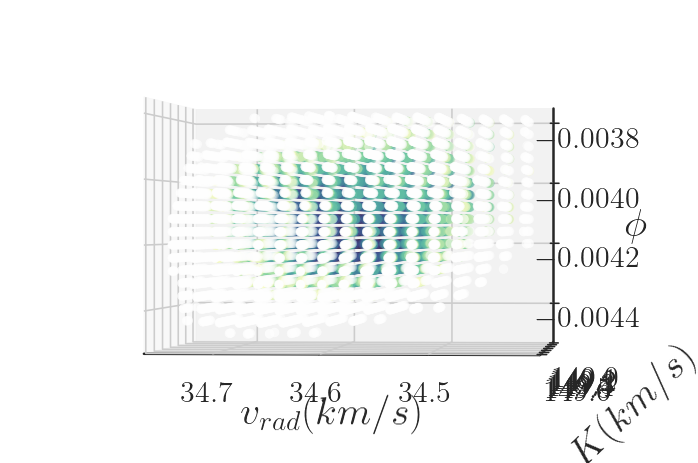

In [25]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.font_manager
from mpl_toolkits.mplot3d import Axes3D
import cmocean
fig = P.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = cmocean.cm.deep_r
ax.scatter(vrad, amp, phase, c=chisq, vmin=vmin, vmax=(vmin+dchisq), cmap=cmap) 
P.ylabel(r'$K (km/s)$', fontsize=20, labelpad=12)
P.xlabel(r'$v_{rad} (km/s)$', fontsize=20, labelpad=12)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'$\phi$', fontsize=20, rotation = 0, labelpad = 12)
ax.tick_params(axis='both', which='major', labelsize=15, direction='inout')
ax.view_init(elev=0., azim=95.)

---
---
###    2d planes passing through best values
    1) fixed semi-amplitude: K = 149.2 -- this value differs in 0.1km/s from the best value!! As we will see, it matches the value found in 2005.

In [26]:
N.unique(amp)

array([149.  , 149.02, 149.04, 149.06, 149.08, 149.1 , 149.12, 149.14,
       149.16, 149.18, 149.2 , 149.22, 149.24, 149.26, 149.28, 149.3 ,
       149.32, 149.34, 149.36, 149.38, 149.4 , 149.42, 149.44, 149.46,
       149.48, 149.5 , 149.52, 149.54, 149.56, 149.58])

In [27]:
# fixed semi-amplitude
ia = amp == 149.22
ypha = N.unique(phase[ia])
xvrad = N.unique(vrad[ia])

# create a mesh and create new matrix with mesh's shape
x, y = N.meshgrid(xvrad, ypha)
m_z = N.ones_like(x)*9999.
m_test = N.ones_like(x)*9999.
for i in range(chisq[ia].shape[0]):
    indx = N.bitwise_and(y == phase[ia][i], x == vrad[ia][i])
    m_z[indx] = chisq[ia][i]
    m_test[indx] = test[ia][i]
    
mask = m_z > (vmin +cut_sigma**2*3.53)
z=N.ma.array(m_z, mask=mask)  
mask1 = m_test >= 1.
c_test=N.ma.array(m_test, mask=mask1)  

#test interpolation, method 2
import matplotlib.tri as tri
# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(vrad[ia], phase[ia])
interpolator = tri.LinearTriInterpolator(triang, chisq[ia])
z = interpolator(x, y)
interpolator_test = tri.LinearTriInterpolator(triang, test[ia])
c_test = interpolator_test(x, y)

print(' Number of points in the fit: ', amp[ia].shape[0])

# find center in the 2d-plane
optimize_func = lambda x: x[0]*vrad[ia]**2 + x[1]*vrad[ia] + x[2]*phase[ia]**2 + x[3]*phase[ia] \
                            + x[4]*vrad[ia]*phase[ia] + x[5] - chisq[ia]
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)

dx = 1./N.sqrt(a - e**2/(4*c))
dy = 1./N.sqrt(c - e**2/(4*a))


#Spot at best values:
w_min = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f
#Residuals
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z

print('Positions of the center in this plane:')
print('V_rad = %3.2f and phi = %1.5f' %(best_x, best_y))
print('dV_rad = %3.2f and dphi = %1.5f' %(dx, dy))

print('\n Min Spot from fit:')
print('Min Chisq = ', w_min)
print('RMS = ', N.sqrt(N.mean(res**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res**2))/2.3) #2params

del(xvrad, ypha, optimize_func, coef, indx)

 Number of points in the fit:  237
Positions of the center in this plane:
V_rad = 34.59 and phi = -0.00411
dV_rad = 0.01 and dphi = 0.00002

 Min Spot from fit:
Min Chisq =  27713.79542175308
RMS =  30.586876943295064
RMS x dchisq = 13.298642149258724


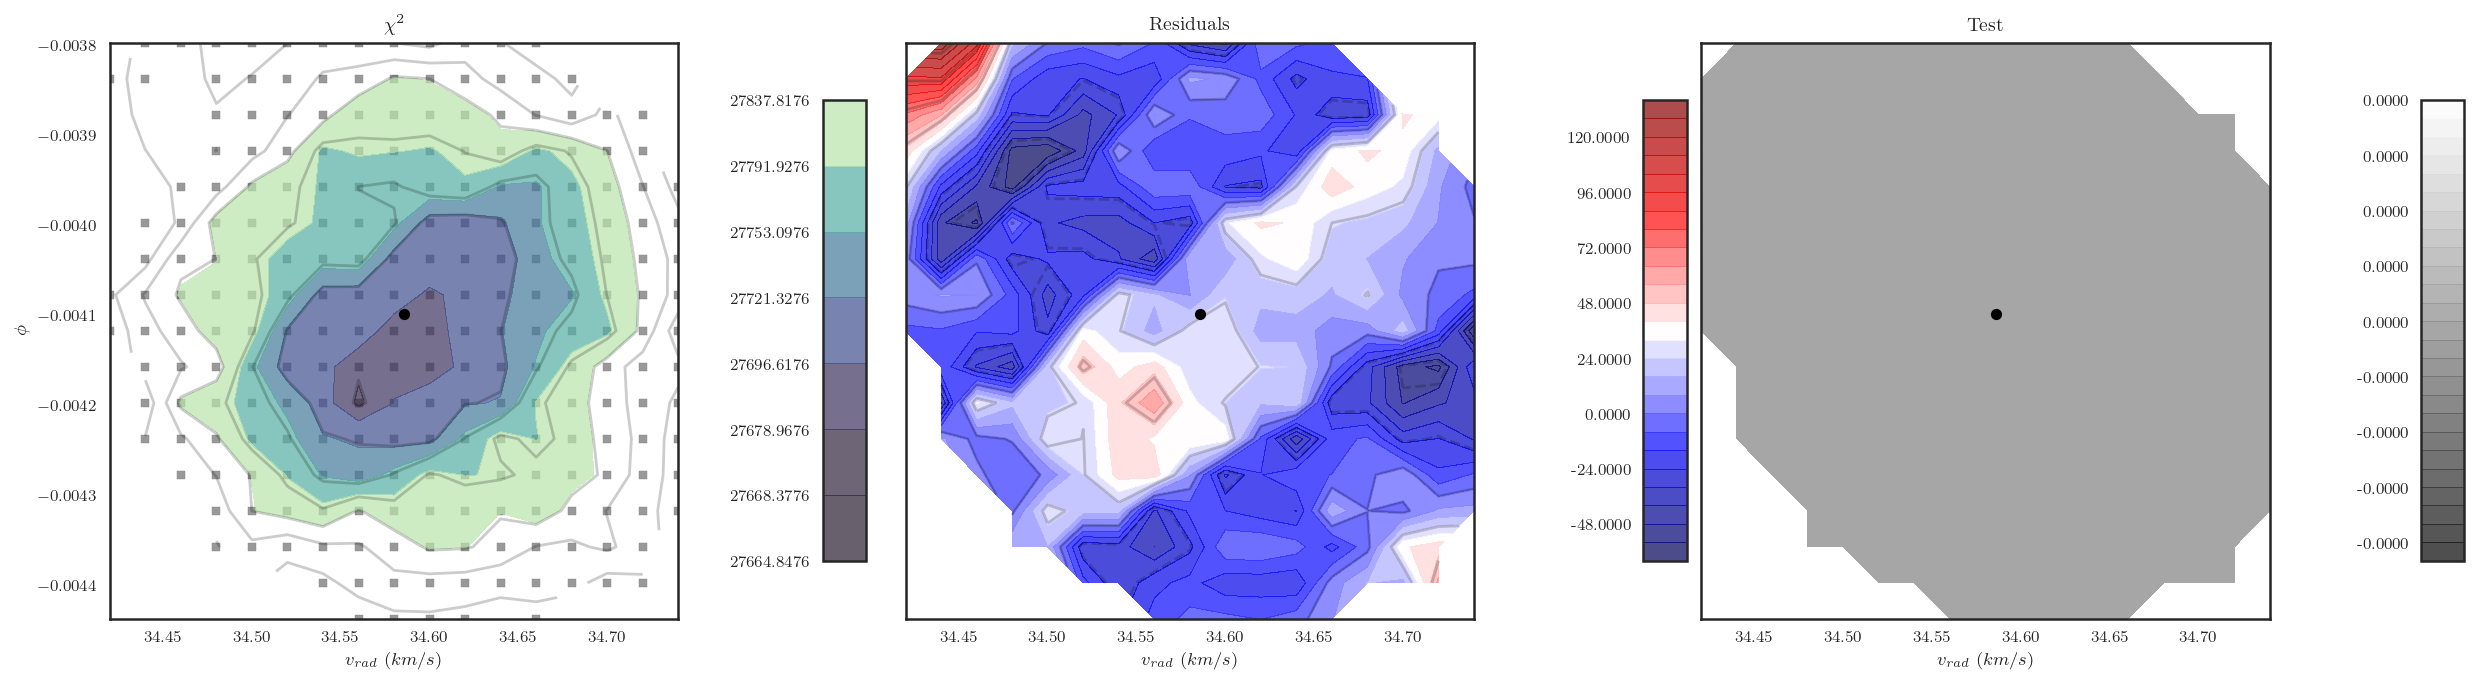

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = P.subplots(1,3, figsize=(15,4), sharey=True)
ax[0].scatter(vrad[ia], phase[ia], marker = 's', s=20, color='gray', alpha=0.8)
ax[0].set_title(r'$\chi^2$')
im = ax[0].contourf(x, y, z, levels=lev, cmap=cmap, alpha=0.7)
ax[0].contour(x, y, z, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%1.4f')
ax[0].set_xlim((x.min(), x.max()))
ax[0].set_ylim((y.min(), y.max()))
ax[0].plot(best_x, best_y, 'x', color='k')
ax[0].plot(Y_min, Z_min, 'o', color='k')
ax[0].set_xlabel(r'$v_{rad}\; (km/s)$')
ax[0].set_ylabel(r'$\phi$')

# Residual
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x, y, res, 30, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%1.4f')
ax[1].contour(x, y, res, colors='k', alpha=0.2)
ax[1].set_xlim((x.min(), x.max()))
ax[1].set_ylim((y.min(), y.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].plot(Y_min, Z_min, 'o', color='k')
ax[1].set_xlabel(r'$v_{rad}\; (km/s)$')

# Test
ax[2].set_title('Test')
im2 = ax[2].contourf(x, y, c_test, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%1.4f')
ax[2].set_xlim((x.min(), x.max()))
ax[2].set_ylim((y.min(), y.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].plot(Y_min, Z_min, 'o', color='k')
ax[2].set_xlabel(r'$v_{rad}\; (km/s)$')
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()
P.show()

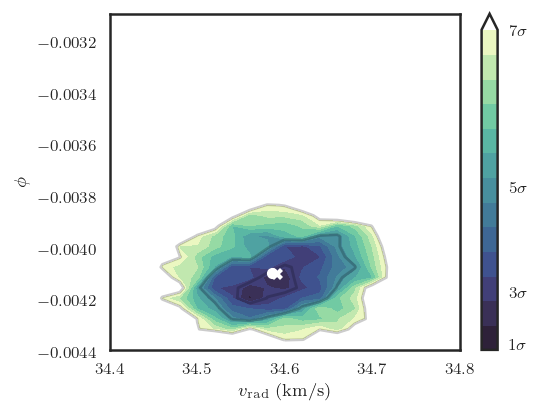

In [29]:
fig, ax = P.subplots(1,1, figsize=(4,3))
cmap.set_over('white')
#ax.set_title(r'$\chi^2$')
im = ax.contourf(x, y, z, levels=N.linspace(lev[0], lev[-1], 14), cmap=cmap, alpha=1., extend='max')
ax.contour(x, y, z, levels=lev_1, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_vrad); ax.set_ylim(lev_phase)
ax.plot(best_x, best_y, 'X', color='w')
ax.plot(Y_min, Z_min, 'o', color='w')
ax.set_xlabel(r'$v_\mathrm{rad}\; (\mathrm{km/s})$')
ax.set_ylabel(r'$\phi$')
P.tight_layout()
P.savefig('figs/K_2004.pdf')

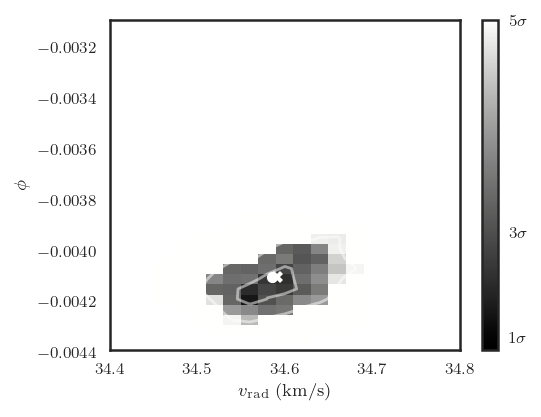

In [21]:
fig, ax = P.subplots(1,1, figsize=(4,3))
cmap.set_over('white')
x_l = N.unique(vrad)[0:2]
dx = (x_l[1] - x_l[0])/2.
y_l = N.unique(phase)[0:2]
dy = (y_l[1] - y_l[0])/2.
im = ax.pcolormesh(x-dx, y-dy, z, vmin=lev[0], vmax=lev[-1], cmap=cm.cm.gray, alpha=1.)
ax.contour(x, y, z, levels=lev_1, colors='w', alpha=0.5)
#add colorbar
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_vrad); ax.set_ylim(lev_phase)
ax.plot(best_x, best_y, 'X', color='w')
ax.plot(Y_min, Z_min, 'o', color='w')
ax.set_xlabel(r'$v_\mathrm{rad}\; (\mathrm{km/s})$')
ax.set_ylabel(r'$\phi$')
P.tight_layout()

---
    2) fixed radial velocity: V_rad = 34.6

In [21]:
N.unique(vrad)

array([34.42, 34.44, 34.46, 34.48, 34.5 , 34.52, 34.54, 34.56, 34.58,
       34.6 , 34.62, 34.64, 34.66, 34.68, 34.7 , 34.72, 34.74])

In [22]:
# fixed vrad
iv = vrad == 34.6

ypha = N.unique(phase[iv])
xamp = N.unique(amp[iv])

# create a mesh and create new matrix with mesh's shape
y, x = N.meshgrid(ypha, xamp)
m_z = N.ones_like(x)*9999.
m_test = N.ones_like(x)*9999.

for i in range(sp_ph[iv].shape[0]):
    indx = N.bitwise_and(y == phase[iv][i], x == amp[iv][i])
    m_z[indx] = chisq[iv][i]
    m_test[indx] = test[iv][i]

mask = m_z > (vmin +cut_sigma**2*3.53/count)
z=N.ma.array(m_z, mask=mask)  
mask1 = m_test >= 1.
c_test=N.ma.array(m_test, mask=mask1) 

#test interpolation, method 2
import matplotlib.tri as tri
# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(amp[iv], phase[iv])
interpolator = tri.LinearTriInterpolator(triang, chisq[iv])
z = interpolator(x, y)
interpolator_test = tri.LinearTriInterpolator(triang, test[iv])
c_test = interpolator_test(x, y)

print(' Number of points in the fit: ', amp[iv].shape[0])

# find center in the 2d-plane
optimize_func = lambda x: x[0]*amp[iv]**2 + x[1]*amp[iv] + x[2]*phase[iv]**2 + x[3]*phase[iv] \
                            + x[4]*amp[iv]*phase[iv] + x[5] - chisq[iv]
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)

#Spot at best values:
w_min = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f
#Residuals
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z

print('Positions of the center in this plane:')
print('K = %3.2f and phi = %1.5f' %(best_x, best_y))
print('dK = %3.2f and dphi = %1.5f' %(dx, dy))

print('\n Min Spot from fit:')
print('Min Chisq = ', w_min)
print('RMS = ', N.sqrt(N.mean(res**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res**2))*(count/2.3)) #2params

del(xamp, ypha, optimize_func, coef, indx)

 Number of points in the fit:  445
Positions of the center in this plane:
K = 149.23 and phi = -0.00412
dK = 0.01 and dphi = 0.00002

 Min Spot from fit:
Min Chisq =  0.9967984279310258
RMS =  0.0011829941585606908
RMS x dchisq = 14.297770269421775


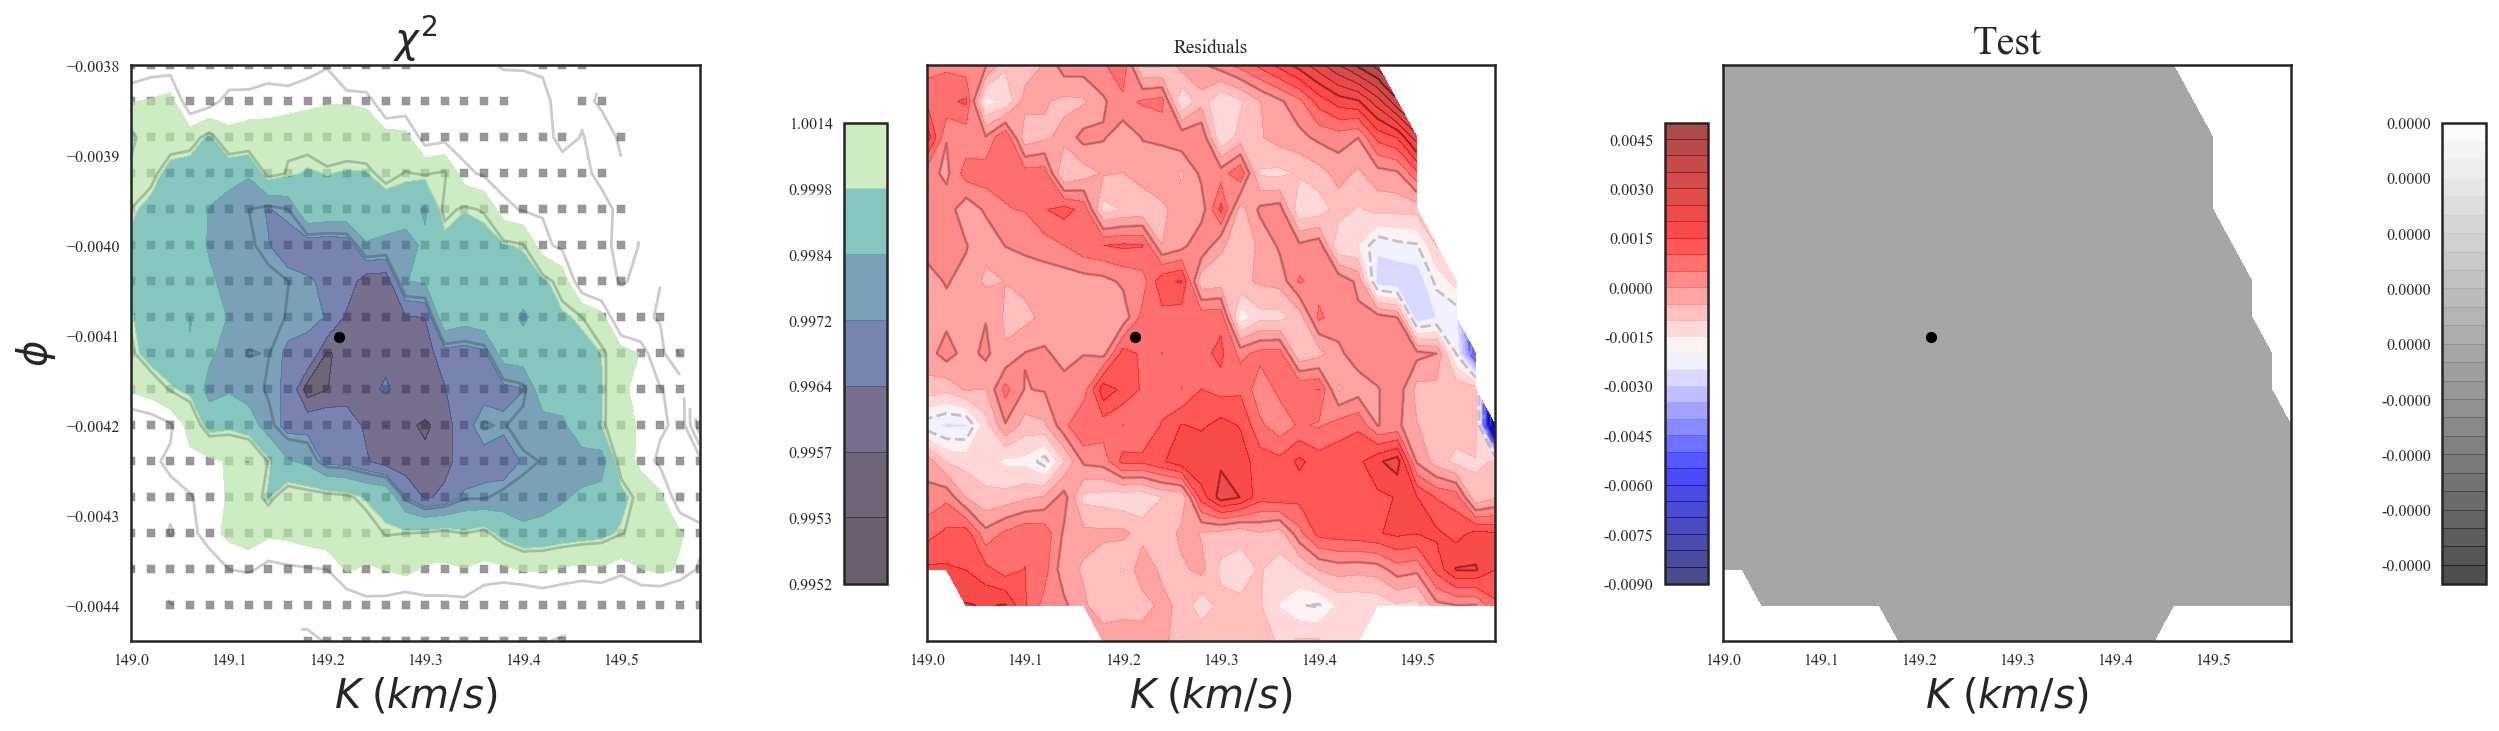

In [23]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = P.subplots(1,3, figsize=(15,4), sharey=True)
ax[0].scatter(amp[iv], phase[iv], marker = 's', s=20, color='gray', alpha=0.8)
#fig.colorbar(im)
ax[0].set_title(r'$\chi^2$', fontsize=20)
im = ax[0].contourf(x, y, z, levels=lev, cmap=cmap, alpha=0.7)
ax[0].contour(x, y, z, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%1.4f')
ax[0].set_xlim((x.min(), x.max()))
ax[0].set_ylim((y.min(), y.max()))
ax[0].plot(best_x, best_y, 'x', color='k')
ax[0].plot(X_min, Z_min, 'o', color='k')
ax[0].set_xlabel(r'$K\; (km/s)$', fontsize=20)
ax[0].set_ylabel(r'$\phi$', fontsize=20)
# Residual
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x, y, res, 30, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%1.4f')
ax[1].contour(x, y, res, colors='k', alpha=0.2)
ax[1].set_xlim((x.min(), x.max()))
ax[1].set_ylim((y.min(), y.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].plot(X_min, Z_min, 'o', color='k')
ax[1].set_xlabel(r'$K\; (km/s)$', fontsize=20)

# Test
ax[2].set_title('Test', fontsize=20)
im2 = ax[2].contourf(x, y, c_test, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%1.4f')
ax[2].set_xlim((x.min(), x.max()))
ax[2].set_ylim((y.min(), y.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].plot(X_min, Z_min, 'o', color='k')
ax[2].set_xlabel(r'$K\; (km/s)$', fontsize=20)
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()
P.show()

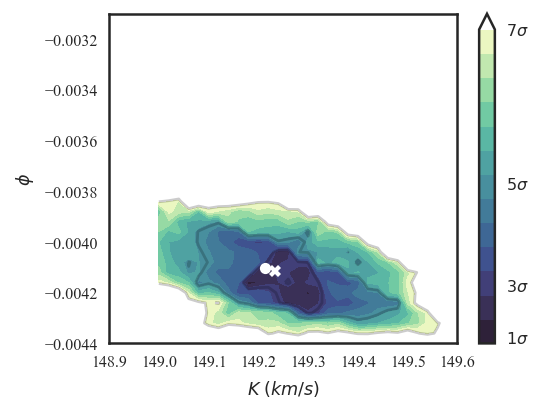

In [24]:

fig, ax = P.subplots(1,1, figsize=(4,3))
cmap.set_over('white')
#ax.set_title(r'$\chi^2$')
im = ax.contourf(x, y, z, levels=N.linspace(lev[0], lev[-1], 14), cmap=cmap, alpha=1., extend='max')
ax.contour(x, y, z, levels=lev_1, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_k); ax.set_ylim(lev_phase)
ax.plot(best_x, best_y, 'X', color='w')
ax.plot(X_min, Z_min, 'o', color='w')
ax.set_xlabel(r'$K \; (km/s)$')
ax.set_ylabel(r'$\phi$')
P.tight_layout()
P.savefig('figs/vrad_2004.pdf')

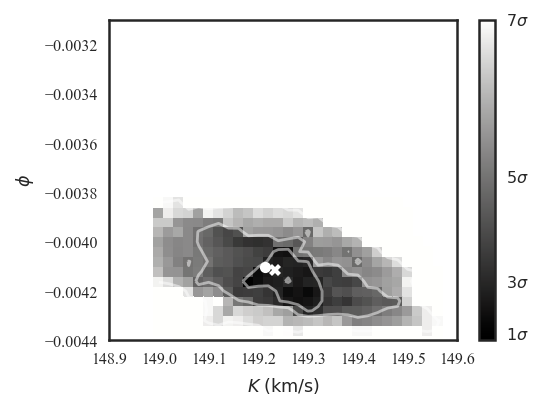

In [25]:
fig, ax = P.subplots(1,1, figsize=(4,3), sharey=True)
cmap.set_over('white')
x_l = N.unique(amp)[0:2]
dx = (x_l[1] - x_l[0])/2.
y_l = N.unique(phase)[0:2]
dy = (y_l[1] - y_l[0])/2.
im = ax.pcolormesh(x-dx, y-dy, z, vmin=lev[0], vmax=lev[-1], cmap=cm.cm.gray, alpha=1.)
#ax.scatter(amp[ip], vrad[ip], marker = 's', s=20, c=sp_ph[ip], cmap=cm.cm.gray, alpha=1.)
ax.contour(x, y, z, levels=lev_1, colors='w', alpha=0.5)
#add colorbar
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_k)
ax.set_ylim(lev_phase)
ax.plot(best_x, best_y, 'X', color='w')
ax.plot(X_min, Z_min, 'o', color='w')
ax.set_xlabel(r'$K \; (\mathrm{km/s})$')
ax.set_ylabel(r'$\phi$')
P.tight_layout()



---
    3) fixed phase: phi = -0.0026

In [26]:
N.unique(phase)

array([-0.00448, -0.00444, -0.0044 , -0.00436, -0.00432, -0.00428,
       -0.00424, -0.0042 , -0.00416, -0.00412, -0.00408, -0.00404,
       -0.004  , -0.00396, -0.00392, -0.00388, -0.00384, -0.0038 ])

In [27]:
# fixed phase
ip = phase == -0.00412
yvrad = N.unique(vrad[ip])
xamp = N.unique(amp[ip])

# create a mesh and create new matrix with mesh's shape
x, y = N.meshgrid(xamp, yvrad)
m_z = N.ones_like(x)*9999.
m_test = N.ones_like(x)*9999.

for i in range(sp_ph[ip].shape[0]):
    indx = N.bitwise_and(x == amp[ip][i], y == vrad[ip][i])
    m_z[indx] = chisq[ip][i]
    m_test[indx] = test[ip][i]

mask = m_z > (vmin+dchisq)
z=N.ma.array(m_z, mask=mask)  
mask1 = m_test >= 1.
c_test=N.ma.array(m_test, mask=mask1)     

#test interpolation, method 2
import matplotlib.tri as tri
# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(amp[ip], vrad[ip])
interpolator = tri.LinearTriInterpolator(triang, chisq[ip])
z = interpolator(x, y)
interpolator_test = tri.LinearTriInterpolator(triang, test[ip])
c_test = interpolator_test(x, y)

print(' Number of points in the fit: ', amp[ip].shape[0])

# find center in the 2d-plane
optimize_func = lambda x: x[0]*amp[ip]**2 + x[1]*amp[ip] + x[2]*vrad[ip]**2 + x[3]*vrad[ip] \
                        + x[4]*amp[ip]*vrad[ip] + x[5] - chisq[ip]
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)

#Spot at best values:
w_min = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f
#Residuals
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z

print('Positions of the center in this plane:')
print('K = %3.2f and Vrad = %1.5f' %(best_x, best_y))
print('dK = %3.2f and dVrad = %1.5f' %(dx, dy))

print('\n Min Spot from fit:')
print('Min Chisq= ', w_min)
print('RMS = ', N.sqrt(N.mean(res**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res**2))*(count/2.3)) #2params

del(yvrad, xamp, optimize_func, coef, indx)

 Number of points in the fit:  436
Positions of the center in this plane:
K = 149.23 and Vrad = 34.58702
dK = 0.01 and dVrad = 0.00002

 Min Spot from fit:
Min Chisq=  0.99657899086219
RMS =  0.00084050134994201
RMS x dchisq = 10.158372402473042


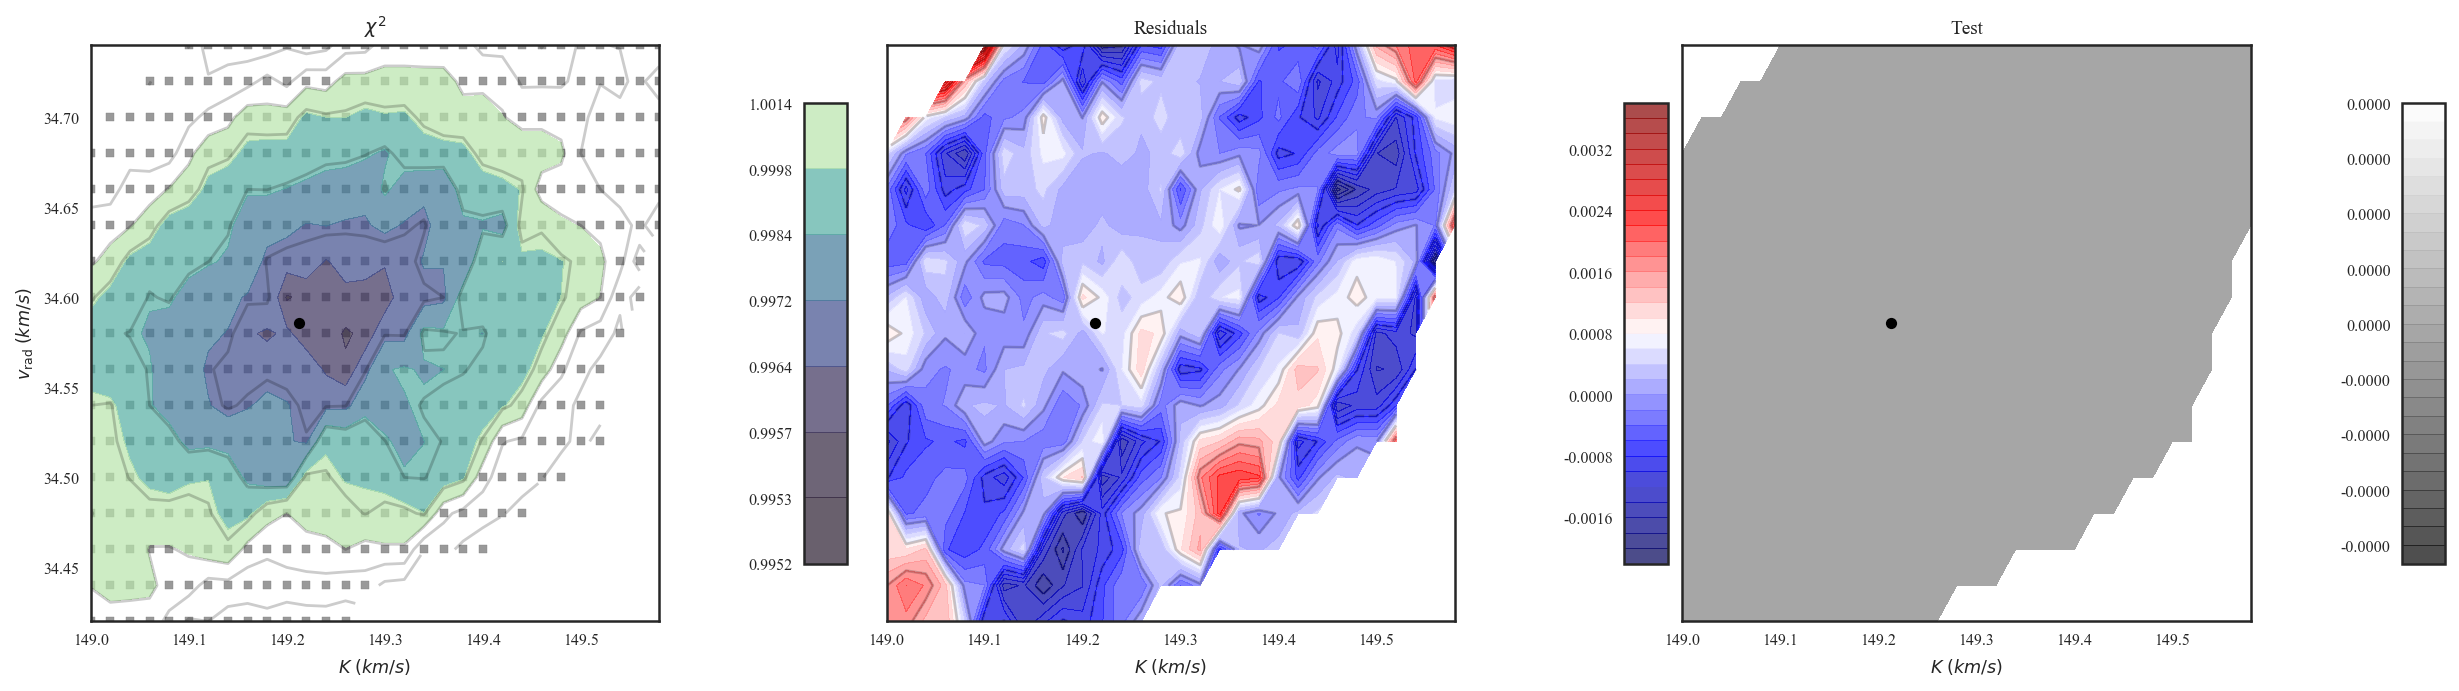

In [28]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = P.subplots(1,3, figsize=(15,4), sharey=True)
ax[0].scatter(amp[ip], vrad[ip], marker = 's', s=20, color='gray', alpha=0.8)
#fig.colorbar(im)
ax[0].set_title(r'$\chi^2$')
im = ax[0].contourf(x, y, z, levels=lev, cmap=cmap, alpha=0.7)
ax[0].contour(x, y, z, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%1.4f')
ax[0].set_xlim((x.min(), x.max()))
ax[0].set_ylim((y.min(), y.max()))
ax[0].plot(best_x, best_y, 'x', color='k')
ax[0].plot(X_min, Y_min, 'o', color='k')
ax[0].set_xlabel(r'$K\; (km/s)$')
ax[0].set_ylabel(r'$v_\mathrm{rad}\; (km/s)$')
# Residual
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x, y, res, 30, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%1.4f')
ax[1].contour(x, y, res, colors='k', alpha=0.2)
ax[1].set_xlim((x.min(), x.max()))
ax[1].set_ylim((y.min(), y.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].plot(X_min, Y_min, 'o', color='k')
ax[1].set_xlabel(r'$K\; (km/s)$')

# Test
ax[2].set_title('Test')
im2 = ax[2].contourf(x, y, c_test, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%1.4f')
ax[2].set_xlim((x.min(), x.max()))
ax[2].set_ylim((y.min(), y.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].plot(X_min, Y_min, 'o', color='k')
ax[2].set_xlabel(r'$K\; (km/s)$')
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()
P.show()

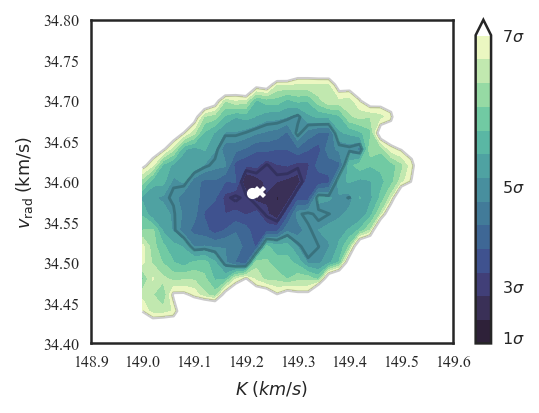

In [29]:
fig, ax = P.subplots(1,1, figsize=(4,3))
cmap.set_over('white')
#ax.set_title(r'$\chi^2$')
im = ax.contourf(x, y, z, levels=N.linspace(lev[0], lev[-1], 14), cmap=cmap, alpha=1., extend='max')
ax.contour(x, y, z, levels=lev_1, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_k); ax.set_ylim(lev_vrad)
ax.plot(best_x, best_y, 'X', color='w')
ax.plot(X_min, Y_min, 'o', color='w')
ax.set_xlabel(r'$K \; (km/s)$')
ax.set_ylabel(r'$v_\mathrm{rad}\; (\mathrm{km/s})$')
P.tight_layout()
P.savefig('figs/phase_2004.pdf')

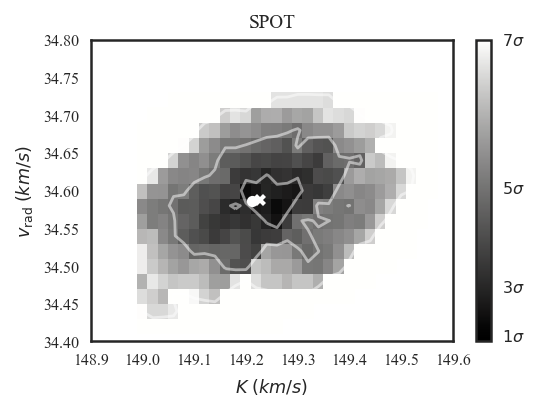

In [30]:
fig, ax = P.subplots(1,1, figsize=(4,3), sharey=True)
cmap.set_over('white')
ax.set_title('SPOT')
x_l = N.unique(amp)[0:2]
dx = (x_l[1] - x_l[0])/2.
y_l = N.unique(vrad)[0:2]
dy = (y_l[1] - y_l[0])/2.
im = ax.pcolormesh(x-dx, y-dy, z, vmin=lev[0], vmax=lev[-1], cmap=cm.cm.gray, alpha=1.)
#ax.scatter(amp[ip], vrad[ip], marker = 's', s=20, c=sp_ph[ip], cmap=cm.cm.gray, alpha=1.)
ax.contour(x, y, z, levels=lev_1, colors='w', alpha=0.5)
# Add colorbar
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_k)
ax.set_ylim(lev_vrad)
ax.plot(best_x, best_y, 'X', color='w')
ax.plot(X_min, Y_min, 'o', color='w')
ax.set_xlabel(r'$K \; (km/s)$')
ax.set_ylabel(r'$v_\mathrm{rad}\; (km/s)$')
P.tight_layout()

## DATA IN 2005  
  \begin{equation*} SP_{\mathrm{ph}} = 0.16 \end{equation*}



We repeat the same procedure showed before, but for 2005.

In [31]:
# load modules
import numpy as N
import matplotlib.pyplot as P
from scipy.optimize import leastsq, least_squares
import cmocean as cm
import matplotlib
P.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", family="Times New Roman", size=20)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#Define the number of sigmas that you want to consider 
nsigma=7.

# Read file with informations in each run
amp, phase, vrad, chisq, s, sp_ph, test, cool, hot = N.genfromtxt('data/search_3d_2005_chipot.txt', unpack=True)

#First read the number of points in the data:
cycle, vr, snI, I, cycleV, vrV, snV, V = rstokes('data/v471tau_05.ss')
count=0
for i in range(len(cycle)):
    count += I[i].shape[0]

#Compute the corresponding variation in reduced chisq
dchisq = nsigma**2*3.53/count
    
# Set global min of chisq
vmin = chisq.min()
print('chisq_min =', vmin)

#Set levels for plotting
lev = [vmin + isigma**2*(3.53/count) for isigma in range(int(nsigma)+1)]
cut_sigma = int(nsigma) + 2
lev_1 = [vmin + isigma**2*(3.53/count) for isigma in range(1,cut_sigma,2)]

#select data within the conditions:
ic = N.bitwise_and(N.bitwise_and(sp_ph <= 0.1605, sp_ph >= 0.1595), test <= 0.005)
amp = amp[ic]; phase = phase[ic]; vrad = vrad[ic]; chisq = chisq[ic]; s = s[ic]
sp_ph = sp_ph[ic]; test = test[ic]; cool = cool[ic]; hot = hot[ic]

#we also add another condition for the data (optional):
isp = N.bitwise_and(chisq >= vmin, chisq <= (vmin + cut_sigma**2*3.53/count))
amp = amp[isp]; phase = phase[isp]; vrad = vrad[isp]; chisq = chisq[isp]; s = s[isp] 
sp_ph = sp_ph[isp]; test = test[isp]; cool = cool[isp]; hot = hot[isp]

# sort in chisq
ic = chisq.argsort()
amp = amp[ic]; phase = phase[ic]; vrad = vrad[ic]; chisq = chisq[ic]; s = s[ic]
sp_ph = sp_ph[ic]; test = test[ic]; cool = cool[ic]; hot = hot[ic]
print(' Number of points in the fit: ', amp.shape[0])
print('\n The lowest spot in the data was at:')
print('K = ', amp[0], 'Vrad = ', vrad[0], 'Phase = ', phase[0])


## 3d minimization of sp_ph - this more accurate if we work with constant spot and then minimize chisq:
optimize_func = lambda x: x[0]*amp**2 + x[1]*vrad**2 + x[2]*phase**2 + x[3]*amp*vrad + x[4]*amp*phase \
                        + x[5]*vrad*phase + x[6]*amp + x[7]*vrad + x[8]*phase + x[9] - chisq

#Second option of minimization
def func(x, datax, sp_ph):
    amp, vrad, phase = datax
    return x[0]*amp**2 + x[1]*vrad**2 + x[2]*phase**2 + x[3]*amp*vrad + x[4]*amp*phase \
           + x[5]*vrad*phase + x[6]*amp + x[7]*vrad + x[8]*phase + x[9] - chisq

coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.])[0]
#datax = (amp,vrad,phase)
#res = least_squares(func, [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.], args=(datax,sp_ph/vmin))
#coef=res.x
a, b, c, d, e, f, g, h, i, j = coef
A = 2.*a*f - d*e; B =  2.*c*d - e*f
C = 4.*a*c - e**2; D =  d*f - 2.*b*e
E = 2.*c*g - e*i; F =  g*f - h*e
G = d**2 - 4.*a*b; H =  d*g - 2.*a*h
I = h*e - d*i; J =  f**2 - 4.*b*c
K =  f*h - 2.*b*i; L =  g*f - d*i
alpha_X = -D/J; beta_X = -(d+f*alpha_X)/(2*b)
alpha_Y = -B/C; beta_Y = -(f+e*alpha_Y)/(2*c)
alpha_Z =  A/G; beta_Z = -(e+d*alpha_Z)/(2*a)

# Best values (or the center of the paraboloid):
X_min = (D*E - B*F)/(A*B - C*D); Y_min = (A*I - B*H)/(A*D + B*G); Z_min = (D*L - A*K)/(B*D + A*J)

# 'Error  bars' - they are fake error bars because we are not minimizing chisq!: 
dX = 1./N.sqrt(2*a + 2*d*beta_X + 2*e*alpha_X + 2*b*beta_X**2 + 2*f*alpha_X*beta_X + 2*c*alpha_X**2)
dY = 1./N.sqrt(2*b + 2*f*beta_Y + 2*d*alpha_Y + 2*c*beta_Y**2 + 2*e*alpha_Y*beta_Y + 2*a*alpha_Y**2)
dZ = 1./N.sqrt(2*c + 2*e*beta_Z + 2*f*alpha_Z + 2*a*beta_Z**2 + 2*d*alpha_Z*beta_Z + 2*b*alpha_Z**2)

dX /= N.sqrt(count)
dY /= N.sqrt(count)
dZ /= N.sqrt(count)

w_min = a*X_min**2 + b*Y_min**2 + c*Z_min**2 + d*X_min*Y_min + e*X_min*Z_min + f*Y_min*Z_min + g*X_min + h*Y_min + i*Z_min + j
residual=(a*amp**2 + b*vrad**2 + c*phase**2 + d*amp*vrad + e*amp*phase + f*vrad*phase + g*amp + h*vrad + i*phase + j - chisq)

print('\n The paraboloid fit returns at the center:')
print('Min chisq = ', w_min)
print('RMS = ', N.sqrt(N.mean(residual**2)))
print('RMS x dchisq =', N.sqrt(N.mean(residual**2))*(count/3.53))#3params

print('\n At coordinates:')
print(r'K = %3.2f, V_rad = %2.2f, and phi = %1.5f' %(X_min, Y_min, Z_min))
print(r'dK = %1.2f, dV_rad = %1.2f, and dphi = %1.5f' %(dX, dY, dZ))

chisq_min = 1.0026
 Number of points in the fit:  3105

 The lowest spot in the data was at:
K =  149.24 Vrad =  34.68 Phase =  -0.00362

 The paraboloid fit returns at the center:
Min chisq =  1.0040582272633856
RMS =  0.0005670492922678337
RMS x dchisq = 7.866403354775018

 At coordinates:
K = 149.32, V_rad = 34.69, and phi = -0.00371
dK = 0.02, dV_rad = 0.01, and dphi = 0.00002


RMS =  0.0005670492922678337
RMS x dchisq = 7.866403354775018


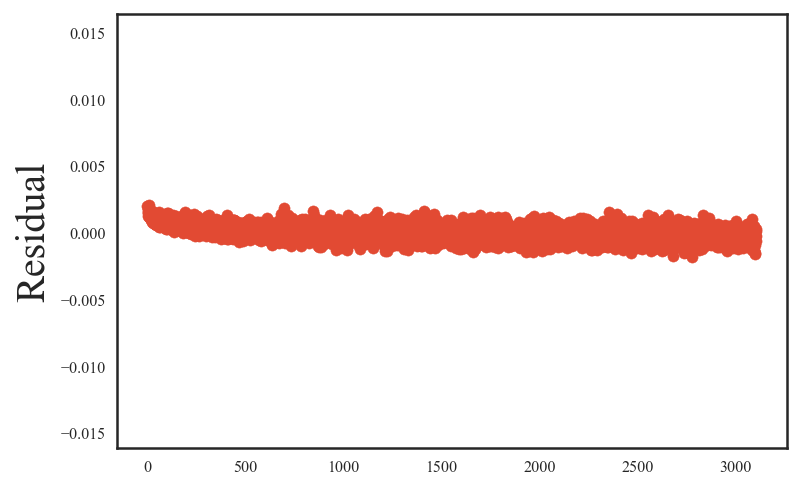

In [32]:
w = a*amp**2 + b*vrad**2 + c*phase**2 + d*amp*vrad + e*amp*phase + f*vrad*phase + g*amp + h*vrad + i*phase + j
residual=(w-chisq)

P.scatter(range(residual.shape[0]), residual)
P.ylabel('Residual', fontsize=20)

print('RMS = ', N.sqrt(N.mean(residual**2)))
print('RMS x dchisq =', N.sqrt(N.mean(residual**2))*(count/3.53))

In [33]:
vmin

1.0026

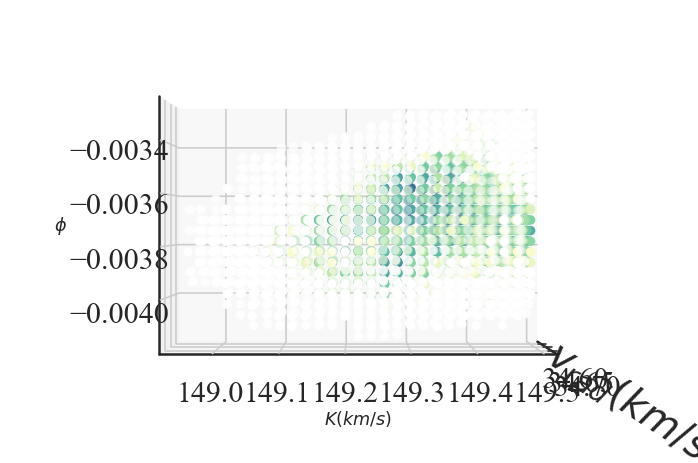

In [34]:
#%matplotlib notebook
%matplotlib inline
import matplotlib.font_manager
from mpl_toolkits.mplot3d import Axes3D
import cmocean
fig = P.figure()
ax = fig.add_subplot(111, projection='3d')
cmap = cmocean.cm.deep_r
ax.scatter(vrad, amp, phase, c=chisq, vmin=vmin, vmax=(vmin+dchisq), cmap=cmap) 
P.ylabel(r'$K (km/s)$', labelpad=12)
P.xlabel(r'$v_{rad} (km/s)$', fontsize=20, labelpad=12)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'$\phi$',  rotation = 0, labelpad = 12)
ax.tick_params(axis='both', which='major', labelsize=15, direction='inout')
ax.view_init(elev=0., azim=0.)

---
---
###    2d planes passing through best values
    1) fixed semi-amplitude: K = 149.2

In [35]:
N.unique(amp)

array([148.96, 148.98, 149.  , 149.02, 149.04, 149.06, 149.08, 149.1 ,
       149.12, 149.14, 149.16, 149.18, 149.2 , 149.22, 149.24, 149.26,
       149.28, 149.3 , 149.32, 149.34, 149.36, 149.38, 149.4 , 149.42,
       149.44, 149.46, 149.48])

In [36]:
# fixed semi-amplitude
ia = amp == 149.3
ypha = N.unique(phase[ia])
xvrad = N.unique(vrad[ia])

# create a mesh and create new matrix with mesh's shape
x, y = N.meshgrid(xvrad, ypha)
m_z = N.ones_like(x)*9999.
m_test = N.ones_like(x)*9999.
for i in range(chisq[ia].shape[0]):
    indx = N.bitwise_and(y == phase[ia][i], x == vrad[ia][i])
    m_z[indx] = chisq[ia][i]
    m_test[indx] = test[ia][i]
    
mask = m_z > (vmin +cut_sigma**2*3.53/count)
z=N.ma.array(m_z, mask=mask)  
mask1 = m_test >= 1.
c_test=N.ma.array(m_test, mask=mask1)  

#test interpolation, method 2
import matplotlib.tri as tri
# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(vrad[ia], phase[ia])
interpolator = tri.LinearTriInterpolator(triang, chisq[ia])
z = interpolator(x, y)
interpolator_test = tri.LinearTriInterpolator(triang, test[ia])
c_test = interpolator_test(x, y)

print(' Number of points in the fit: ', amp[ia].shape[0])

# find center in the 2d-plane
optimize_func = lambda x: x[0]*vrad[ia]**2 + x[1]*vrad[ia] + x[2]*phase[ia]**2 + x[3]*phase[ia] \
                            + x[4]*vrad[ia]*phase[ia] + x[5] - chisq[ia]
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)

dx = 1./N.sqrt(a - e**2/(4*c))
dy = 1./N.sqrt(c - e**2/(4*a))
dx /= N.sqrt(count)
dy /= N.sqrt(count)


#Spot at best values:
w_min = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f
#Residuals
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z

print('Positions of the center in this plane:')
print('V_rad = %3.2f and phi = %1.5f' %(best_x, best_y))
print('dV_rad = %3.2f and dphi = %1.5f' %(dx, dy))

print('\n Min Spot from fit:')
print('Min Chisq = ', w_min)
print('RMS = ', N.sqrt(N.mean(res**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res**2))*(count/2.3)) #2params

del(xvrad, ypha, optimize_func, coef, indx)

 Number of points in the fit:  149
Positions of the center in this plane:
V_rad = 34.69 and phi = -0.00371
dV_rad = 0.01 and dphi = 0.00003

 Min Spot from fit:
Min Chisq =  1.0036605939438914
RMS =  0.0005457964388173279
RMS x dchisq = 11.62071809081937


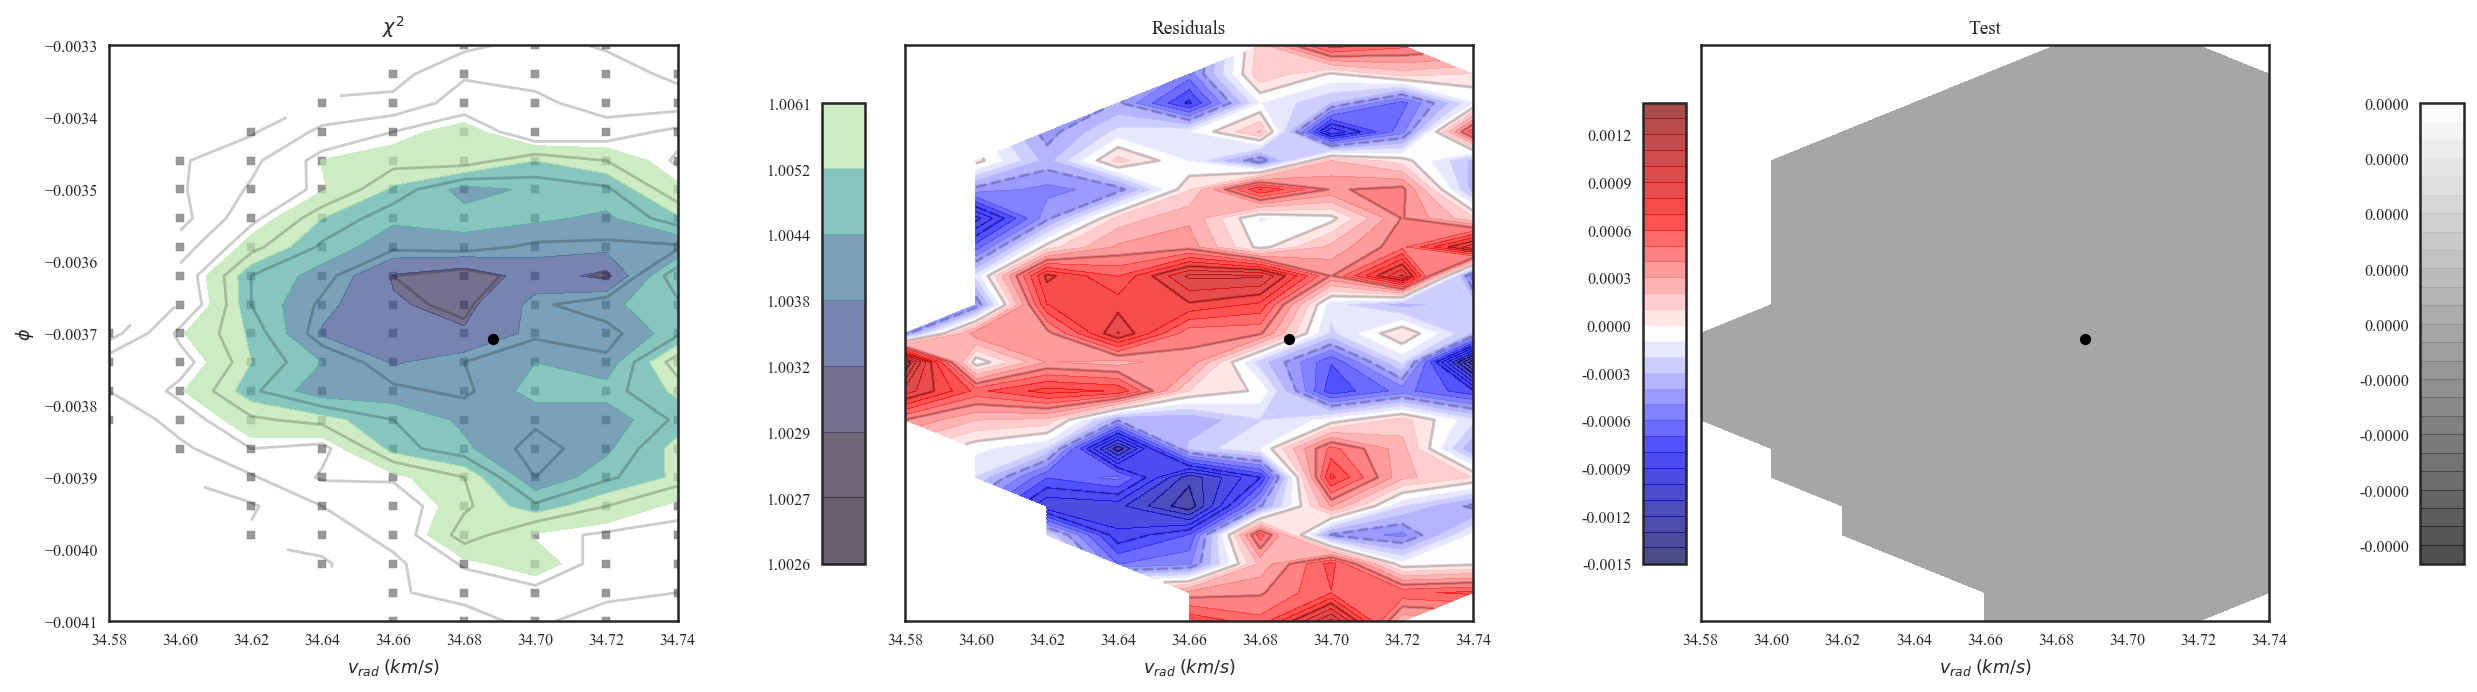

In [37]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = P.subplots(1,3, figsize=(15,4), sharey=True)
ax[0].scatter(vrad[ia], phase[ia], marker = 's', s=20, color='gray', alpha=0.8)
ax[0].set_title(r'$\chi^2$')
im = ax[0].contourf(x, y, z, levels=lev, cmap=cmap, alpha=0.7)
ax[0].contour(x, y, z, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%1.4f')
ax[0].set_xlim((x.min(), x.max()))
ax[0].set_ylim((y.min(), y.max()))
ax[0].plot(best_x, best_y, 'x', color='k')
ax[0].plot(Y_min, Z_min, 'o', color='k')
ax[0].set_xlabel(r'$v_{rad}\; (km/s)$')
ax[0].set_ylabel(r'$\phi$')

# Residual
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x, y, res, 30, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%1.4f')
ax[1].contour(x, y, res, colors='k', alpha=0.2)
ax[1].set_xlim((x.min(), x.max()))
ax[1].set_ylim((y.min(), y.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].plot(Y_min, Z_min, 'o', color='k')
ax[1].set_xlabel(r'$v_{rad}\; (km/s)$')

# Test
ax[2].set_title('Test')
im2 = ax[2].contourf(x, y, c_test, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%1.4f')
ax[2].set_xlim((x.min(), x.max()))
ax[2].set_ylim((y.min(), y.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].plot(Y_min, Z_min, 'o', color='k')
ax[2].set_xlabel(r'$v_{rad}\; (km/s)$')
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()
P.show()

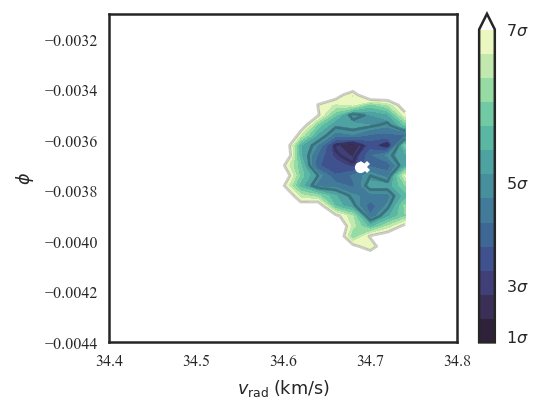

In [38]:
fig, ax = P.subplots(1,1, figsize=(4,3))
cmap.set_over('white')
#ax.set_title(r'$\chi^2$')
im = ax.contourf(x, y, z, levels=N.linspace(lev[0], lev[-1], 14), cmap=cmap, alpha=1., extend='max')
ax.contour(x, y, z, levels=lev_1, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_vrad); ax.set_ylim(lev_phase)
ax.plot(best_x, best_y, 'X', color='w')
ax.plot(Y_min, Z_min, 'o', color='w')
ax.set_xlabel(r'$v_\mathrm{rad}\; (\mathrm{km/s})$')
ax.set_ylabel(r'$\phi$')
P.tight_layout()
P.savefig('figs/K_2005.pdf')

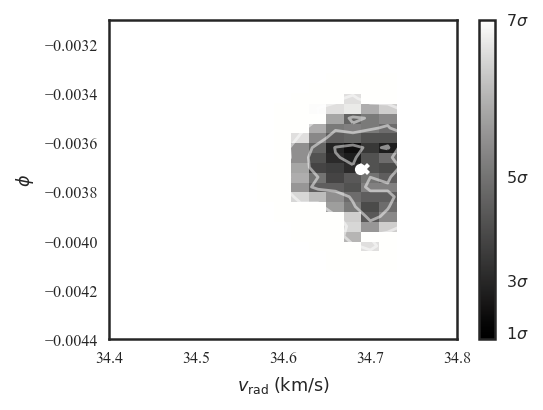

In [39]:
fig, ax = P.subplots(1,1, figsize=(4,3))
cmap.set_over('white')
x_l = N.unique(vrad)[0:2]
dx = (x_l[1] - x_l[0])/2.
y_l = N.unique(phase)[0:2]
dy = (y_l[1] - y_l[0])/2.
im = ax.pcolormesh(x-dx, y-dy, z, vmin=lev[0], vmax=lev[-1], cmap=cm.cm.gray, alpha=1.)
ax.contour(x, y, z, levels=lev_1, colors='w', alpha=0.5)
#add colorbar
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_vrad); ax.set_ylim(lev_phase)
ax.plot(best_x, best_y, 'X', color='w')
ax.plot(Y_min, Z_min, 'o', color='w')
ax.set_xlabel(r'$v_\mathrm{rad}\; (\mathrm{km/s})$')
ax.set_ylabel(r'$\phi$')
P.tight_layout()

# ---
    2) fixed radial velocity: V_rad = 35.0

In [228]:
N.unique(vrad)

array([34.58, 34.6 , 34.62, 34.64, 34.66, 34.68, 34.7 , 34.72, 34.74])

In [229]:
# fixed vrad
iv = vrad == 34.7

ypha = N.unique(phase[iv])
xamp = N.unique(amp[iv])

# create a mesh and create new matrix with mesh's shape
y, x = N.meshgrid(ypha, xamp)
m_z = N.ones_like(x)*9999.
m_test = N.ones_like(x)*9999.

for i in range(sp_ph[iv].shape[0]):
    indx = N.bitwise_and(y == phase[iv][i], x == amp[iv][i])
    m_z[indx] = chisq[iv][i]
    m_test[indx] = test[iv][i]

mask = m_z > (vmin +cut_sigma**2*3.53/count)
z=N.ma.array(m_z, mask=mask)  
mask1 = m_test >= 1.
c_test=N.ma.array(m_test, mask=mask1) 

#test interpolation, method 2
import matplotlib.tri as tri
# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(amp[iv], phase[iv])
interpolator = tri.LinearTriInterpolator(triang, chisq[iv])
z = interpolator(x, y)
interpolator_test = tri.LinearTriInterpolator(triang, test[iv])
c_test = interpolator_test(x, y)

print(' Number of points in the fit: ', amp[iv].shape[0])

# find center in the 2d-plane
optimize_func = lambda x: x[0]*amp[iv]**2 + x[1]*amp[iv] + x[2]*phase[iv]**2 + x[3]*phase[iv] \
                            + x[4]*amp[iv]*phase[iv] + x[5] - chisq[iv]
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)

#Spot at best values:
w_min = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f
#Residuals
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z

print('Positions of the center in this plane:')
print('K = %3.2f and phi = %1.5f' %(best_x, best_y))
print('dK = %3.2f and dphi = %1.5f' %(dx, dy))

print('\n Min Spot from fit:')
print('Min Chisq = ', w_min)
print('RMS = ', N.sqrt(N.mean(res**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res**2))*(count/2.3)) #2params

del(xamp, ypha, optimize_func, coef, indx)

 Number of points in the fit:  464
Positions of the center in this plane:
K = 149.31 and phi = -0.00371
dK = 0.01 and dphi = 0.00002

 Min Spot from fit:
Min Chisq =  1.0040297071959685
RMS =  0.0005766238441400881
RMS x dchisq = 11.982744893269414


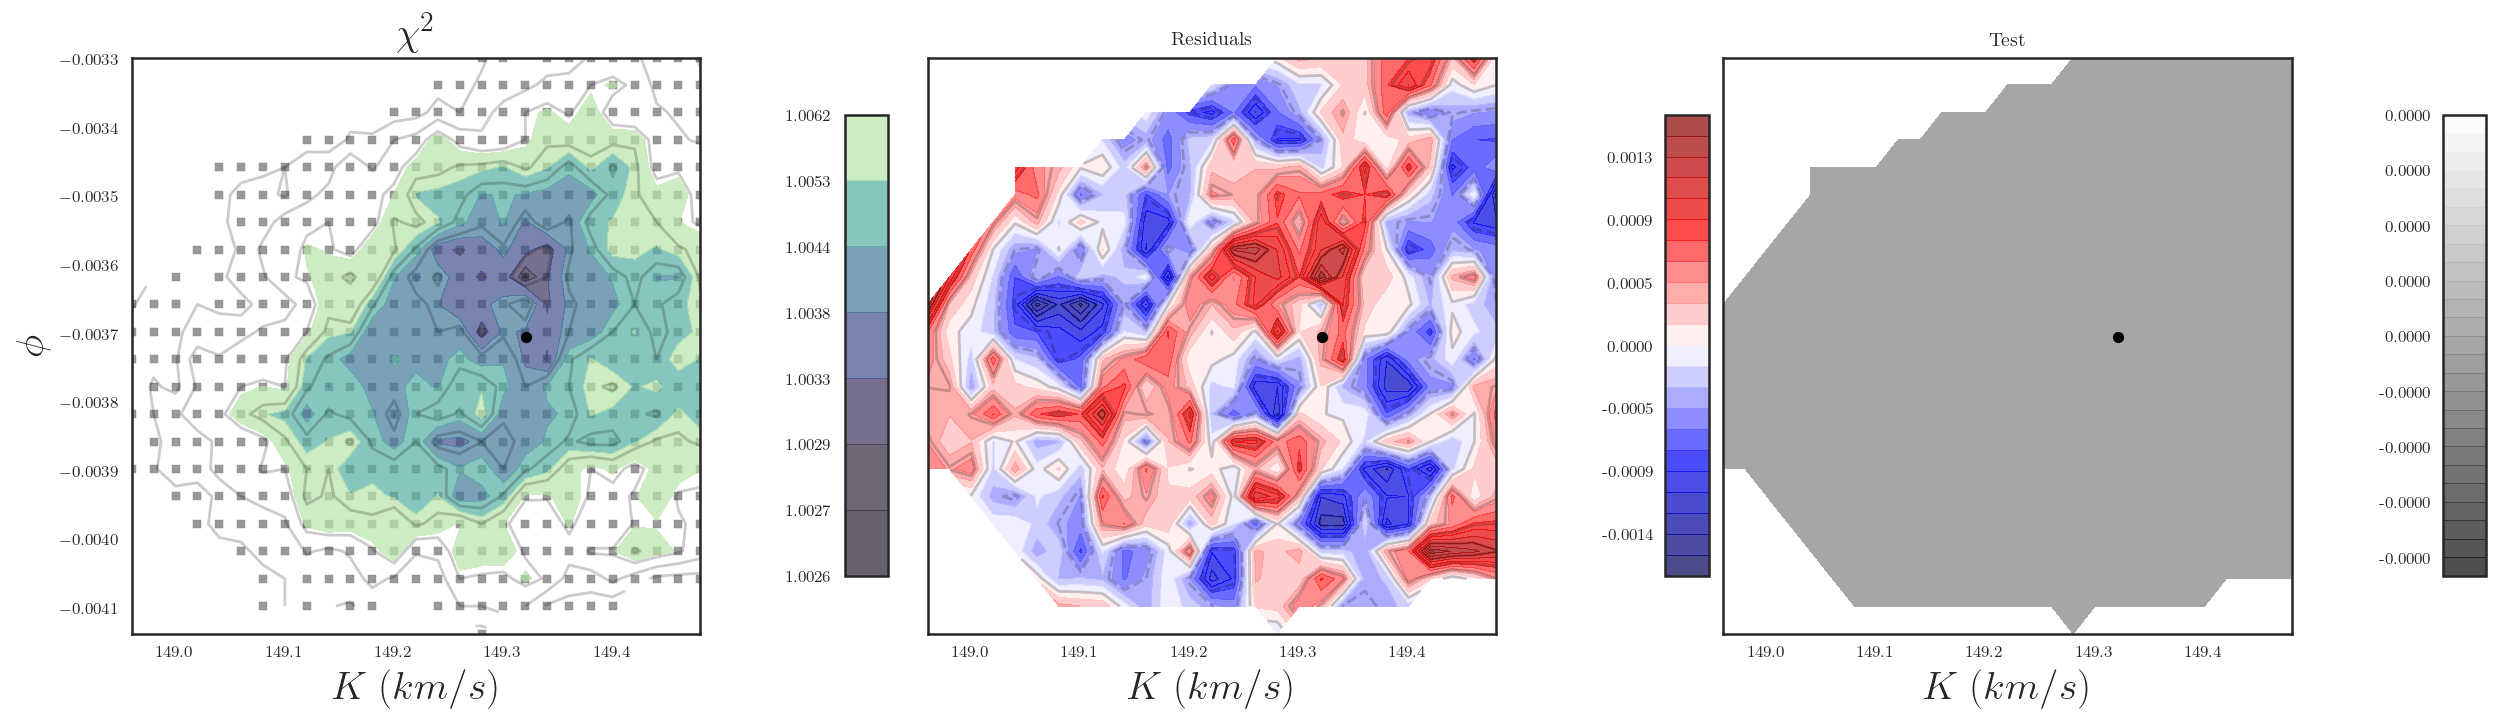

In [230]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = P.subplots(1,3, figsize=(15,4), sharey=True)
ax[0].scatter(amp[iv], phase[iv], marker = 's', s=20, color='gray', alpha=0.8)
#fig.colorbar(im)
ax[0].set_title(r'$\chi^2$', fontsize=20)
im = ax[0].contourf(x, y, z, levels=lev, cmap=cmap, alpha=0.7)
ax[0].contour(x, y, z, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%1.4f')
ax[0].set_xlim((x.min(), x.max()))
ax[0].set_ylim((y.min(), y.max()))
ax[0].plot(best_x, best_y, 'x', color='k')
ax[0].plot(X_min, Z_min, 'o', color='k')
ax[0].set_xlabel(r'$K\; (km/s)$', fontsize=20)
ax[0].set_ylabel(r'$\phi$', fontsize=20)
# Residual
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x, y, res, 30, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%1.4f')
ax[1].contour(x, y, res, colors='k', alpha=0.2)
ax[1].set_xlim((x.min(), x.max()))
ax[1].set_ylim((y.min(), y.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].plot(X_min, Z_min, 'o', color='k')
ax[1].set_xlabel(r'$K\; (km/s)$', fontsize=20)

# Test
ax[2].set_title('Test')
im2 = ax[2].contourf(x, y, c_test, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%1.4f')
ax[2].set_xlim((x.min(), x.max()))
ax[2].set_ylim((y.min(), y.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].plot(X_min, Z_min, 'o', color='k')
ax[2].set_xlabel(r'$K\; (km/s)$', fontsize=20)
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()
P.show()

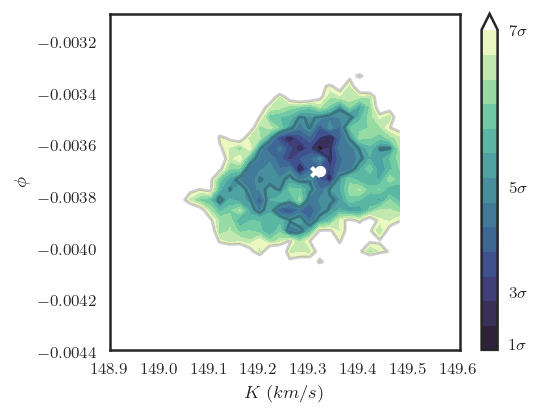

In [233]:
fig, ax = P.subplots(1,1, figsize=(4,3))
cmap.set_over('white')
#ax.set_title(r'$\chi^2$')
im = ax.contourf(x, y, z, levels=N.linspace(lev[0], lev[-1], 14), cmap=cmap, alpha=1., extend='max')
ax.contour(x, y, z, levels=lev_1, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_k); ax.set_ylim(lev_phase)
ax.plot(best_x, best_y, 'X', color='w')
ax.plot(X_min, Z_min, 'o', color='w')
ax.set_xlabel(r'$K \; (km/s)$')
ax.set_ylabel(r'$\phi$')
P.tight_layout()
P.savefig('figs/vrad_2005.pdf')

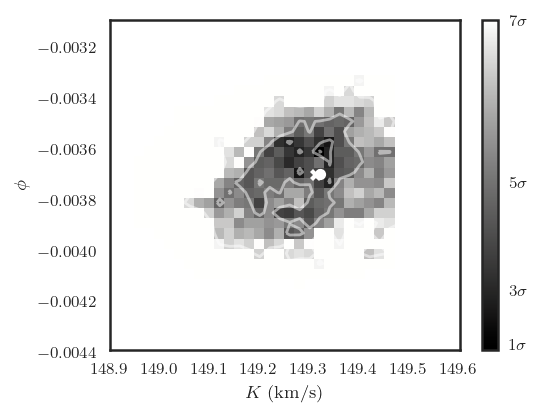

In [234]:
fig, ax = P.subplots(1,1, figsize=(4,3), sharey=True)
cmap.set_over('white')
x_l = N.unique(amp)[0:2]
dx = (x_l[1] - x_l[0])/2.
y_l = N.unique(phase)[0:2]
dy = (y_l[1] - y_l[0])/2.
im = ax.pcolormesh(x-dx, y-dy, z, vmin=lev[0], vmax=lev[-1], cmap=cm.cm.gray, alpha=1.)
#ax.scatter(amp[ip], vrad[ip], marker = 's', s=20, c=sp_ph[ip], cmap=cm.cm.gray, alpha=1.)
ax.contour(x, y, z, levels=lev_1, colors='w', alpha=0.5)
#add colorbar
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_k)
ax.set_ylim(lev_phase)
ax.plot(best_x, best_y, 'X', color='w')
ax.plot(X_min, Z_min, 'o', color='w')
ax.set_xlabel(r'$K \; (\mathrm{km/s})$')
ax.set_ylabel(r'$\phi$')
P.tight_layout()




---
    3) fixed phase: phi = -0.0042

In [235]:
N.unique(phase)

array([-0.00414, -0.0041 , -0.00406, -0.00402, -0.00398, -0.00394,
       -0.0039 , -0.00386, -0.00382, -0.00378, -0.00374, -0.0037 ,
       -0.00366, -0.00362, -0.00358, -0.00354, -0.0035 , -0.00346,
       -0.00342, -0.00338, -0.00334, -0.0033 ])

In [236]:
# fixed phase
ip = phase == -0.00366
yvrad = N.unique(vrad[ip])
xamp = N.unique(amp[ip])

# create a mesh and create new matrix with mesh's shape
x, y = N.meshgrid(xamp, yvrad)
m_z = N.ones_like(x)*9999.
m_test = N.ones_like(x)*9999.

for i in range(sp_ph[ip].shape[0]):
    indx = N.bitwise_and(x == amp[ip][i], y == vrad[ip][i])
    m_z[indx] = chisq[ip][i]
    m_test[indx] = test[ip][i]

mask = m_z > (vmin+dchisq)
z=N.ma.array(m_z, mask=mask)  
mask1 = m_test >= 1.
c_test=N.ma.array(m_test, mask=mask1)     

#test interpolation, method 2
import matplotlib.tri as tri
# Perform linear interpolation of the data (x,y)
# on a grid defined by (xi,yi)
triang = tri.Triangulation(amp[ip], vrad[ip])
interpolator = tri.LinearTriInterpolator(triang, chisq[ip])
z = interpolator(x, y)
interpolator_test = tri.LinearTriInterpolator(triang, test[ip])
c_test = interpolator_test(x, y)

print(' Number of points in the fit: ', amp[ip].shape[0])

# find center in the 2d-plane
optimize_func = lambda x: x[0]*amp[ip]**2 + x[1]*amp[ip] + x[2]*vrad[ip]**2 + x[3]*vrad[ip] \
                        + x[4]*amp[ip]*vrad[ip] + x[5] - chisq[ip]
coef = leastsq(optimize_func, [1.,1.,1.,1.,1.,1.])[0]
a, b, c, d, e, f = coef.copy()
best_x = 1./(4*a*c/e - e)*(d - 2.*c*b/e)
best_y = 1./(4*a*c/e - e)*(b - 2.*a*d/e)

#Spot at best values:
w_min = a*best_x**2 + b*best_x + c*best_y**2 + d*best_y + e*best_x*best_y + f
#Residuals
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z

print('Positions of the center in this plane:')
print('K = %3.2f and Vrad = %1.5f' %(best_x, best_y))
print('dK = %3.2f and dVrad = %1.5f' %(dx, dy))

print('\n Min Spot from fit:')
print('Min Chisq= ', w_min)
print('RMS = ', N.sqrt(N.mean(res**2)))
print('RMS x dchisq =', N.sqrt(N.mean(res**2))*(count/2.3)) #2params

del(yvrad, xamp, optimize_func, coef, indx)

 Number of points in the fit:  191
Positions of the center in this plane:
K = 149.32 and Vrad = 34.68530
dK = 0.01 and dVrad = 0.00002

 Min Spot from fit:
Min Chisq=  1.003869033484989
RMS =  0.0005393906734078217
RMS x dchisq = 11.209007228782717


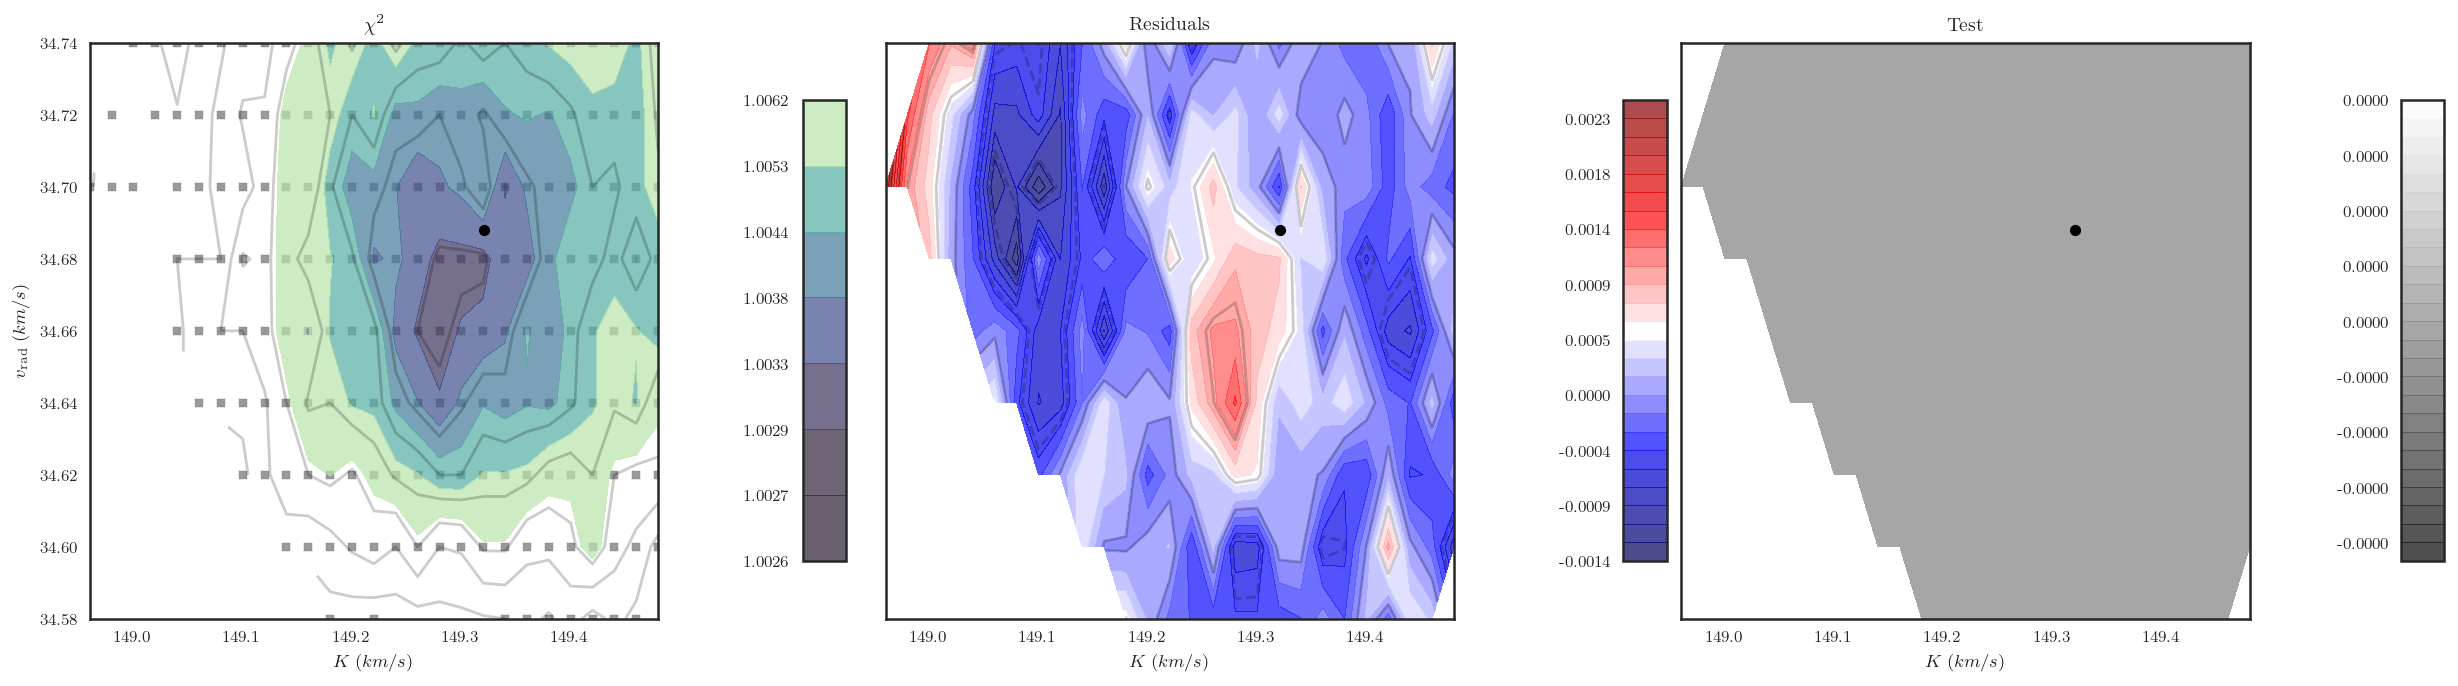

In [237]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = P.subplots(1,3, figsize=(15,4), sharey=True)
ax[0].scatter(amp[ip], vrad[ip], marker = 's', s=20, color='gray', alpha=0.8)
#fig.colorbar(im)
ax[0].set_title(r'$\chi^2$')
im = ax[0].contourf(x, y, z, levels=lev, cmap=cmap, alpha=0.7)
ax[0].contour(x, y, z, colors='k', alpha=0.2)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax = fig.add_axes([0.33, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im, cax = cax, ticklocation = 'left', format = '%1.4f')
ax[0].set_xlim((x.min(), x.max()))
ax[0].set_ylim((y.min(), y.max()))
ax[0].plot(best_x, best_y, 'x', color='k')
ax[0].plot(X_min, Y_min, 'o', color='k')
ax[0].set_xlabel(r'$K\; (km/s)$')
ax[0].set_ylabel(r'$v_\mathrm{rad}\; (km/s)$')
# Residual
res = a*x**2 + b*x + c*y**2 + d*y + e*x*y + f - z
ax[1].set_title('Residuals')
im1 = ax[1].contourf(x, y, res, 30, cmap='seismic', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax1 = fig.add_axes([0.71, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im1, cax = cax1, ticklocation = 'left', format = '%1.4f')
ax[1].contour(x, y, res, colors='k', alpha=0.2)
ax[1].set_xlim((x.min(), x.max()))
ax[1].set_ylim((y.min(), y.max()))
ax[1].plot(best_x, best_y, 'x', color='k')
ax[1].plot(X_min, Y_min, 'o', color='k')
ax[1].set_xlabel(r'$K\; (km/s)$')

# Test
ax[2].set_title('Test')
im2 = ax[2].contourf(x, y, c_test, 30, cmap='gray', alpha=0.7)
# Add colorbar
divider = make_axes_locatable(ax[0])
cax2 = fig.add_axes([1.07, 0.10, 0.02, 0.8])
cbar = fig.colorbar(im2, cax = cax2, ticklocation = 'left', format = '%1.4f')
ax[2].set_xlim((x.min(), x.max()))
ax[2].set_ylim((y.min(), y.max()))
ax[2].plot(best_x, best_y, 'x', color='k')
ax[2].plot(X_min, Y_min, 'o', color='k')
ax[2].set_xlabel(r'$K\; (km/s)$')
fig.subplots_adjust(left = .0, right = 1., top = 1., bottom = .0, wspace = .4, hspace = .1)
#P.tight_layout()
P.show()

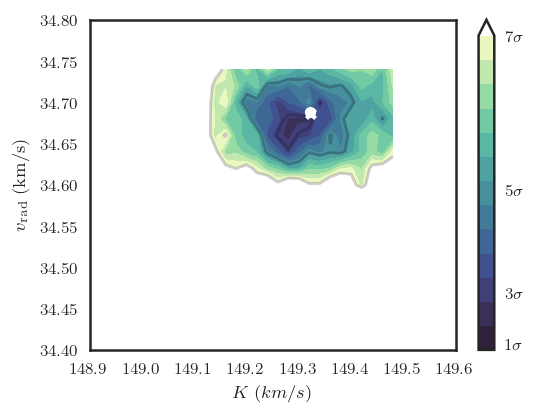

In [239]:
fig, ax = P.subplots(1,1, figsize=(4,3))
cmap.set_over('white')
#ax.set_title(r'$\chi^2$')
im = ax.contourf(x, y, z, levels=N.linspace(lev[0], lev[-1], 14), cmap=cmap, alpha=1., extend='max')
ax.contour(x, y, z, levels=lev_1, colors='k', alpha=0.2)
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_k); ax.set_ylim(lev_vrad)
ax.plot(best_x, best_y, 'X', color='w')
ax.plot(X_min, Y_min, 'o', color='w')
ax.set_xlabel(r'$K \; (km/s)$')
ax.set_ylabel(r'$v_\mathrm{rad}\; (\mathrm{km/s})$')
P.tight_layout()
P.savefig('figs/phase_2005.pdf')

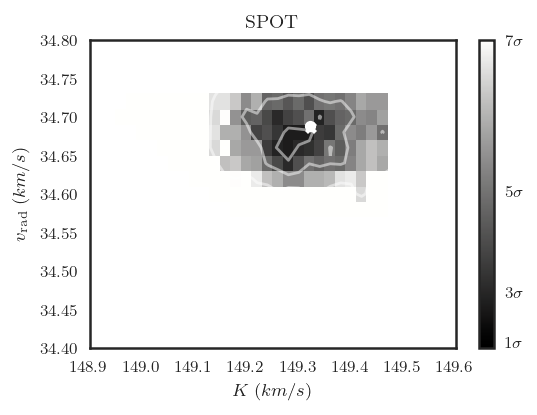

In [240]:
fig, ax = P.subplots(1,1, figsize=(4,3), sharey=True)
cmap.set_over('white')
ax.set_title('SPOT')
x_l = N.unique(amp)[0:2]
dx = (x_l[1] - x_l[0])/2.
y_l = N.unique(vrad)[0:2]
dy = (y_l[1] - y_l[0])/2.
im = ax.pcolormesh(x-dx, y-dy, z, vmin=lev[0], vmax=lev[-1], cmap=cm.cm.gray, alpha=1.)
#ax.scatter(amp[ip], vrad[ip], marker = 's', s=20, c=sp_ph[ip], cmap=cm.cm.gray, alpha=1.)
ax.contour(x, y, z, levels=lev_1, colors='w', alpha=0.5)
# Add colorbar
cbar = fig.colorbar(im, ticks=lev_1, ticklocation = 'right', format = '%1.4f')
cbar.ax.set_yticklabels([r'$ %1d \sigma$' %isig for isig in range(1,cut_sigma,2)])
ax.set_xlim(lev_k)
ax.set_ylim(lev_vrad)
ax.plot(best_x, best_y, 'X', color='w')
ax.plot(X_min, Y_min, 'o', color='w')
ax.set_xlabel(r'$K \; (km/s)$')
ax.set_ylabel(r'$v_\mathrm{rad}\; (km/s)$')
P.tight_layout()


# Summary 

We performed a 3d minimization for the data in both epochs, 2004 and 2005. The results and "error bars" found were the following: 




|           Parameter   | 2004                    |  2005                     |
|              :---:    | :---:                   | :---:                     |
|$K$ (km/s)             | $149.21 \pm 0.02$       | $149.32 \pm 0.02$         |  
|$v_\mathrm{rad}$ (km/s)| $34.59 \pm 0.01$        | $34.69  \pm 0.1$          |
|$\phi$                 | $-0.00410 \pm 0.00002$  | $-0.00371 \pm 0.00002$    | 

The semi-amplitude found in $2004$ was $149.5$ km/s, whereas in $2005$ it was $149.4$ km/s. The "error bar" in 2005 was more precise for this quantity and, because ultimately we want to chose the same value of K for both epochs, we decide to keep the value of $2005$. Then, we chose the best values for $V_\mathrm{rad}$ and $\phi$ in $2004$ by looking for the center in the plane with $K = 149.4$ km/s. 

The parameters that will be used in each epoch are:



|           Parameter   | 2004                    |  2005                     |
|              :---:    | :---:                   | :---:                     |
|$K$ (km/s)             | $149.3$       | $149.3$         |  
|$v_\mathrm{rad}$ (km/s)| $34.59$        | $34.69$          |
|$\phi$                 | $-0.00410$  | $-0.00371$    | 


In [92]:
9.7/200


0.048499999999999995